<a href="https://colab.research.google.com/github/Andrezanincruz01/DissertacaoAndre/blob/main/Aplica%C3%A7%C3%B5es_PGMMOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== Resultados Multi-Start =====

--- Início 1 ---
Ponto inicial (após projeção): [ -8.55784713  18.32422266  10.81251729  19.47480012 -11.67338152]
Ponto ótimo x*: [-20.         -19.90095548  17.60784019 -10.40561715 -11.72080475]
Vetor do subproblema final: [-1.27866429e-15 -1.05647485e-01  3.32787688e-01 -5.21201936e-02
 -3.33217671e-03]
Número de iterações: 49
Valor final de φ: -0.2624493112531311
Imagem da solução ótima F(x*): [np.float64(-214837.64635061103), np.float64(-105.64844198560947)]

--- Início 2 ---
Ponto inicial (após projeção): [-14.52331805  16.33495209 -17.25445928 -16.98669111   1.74138758]
Ponto ótimo x*: [-20.          -9.9658296  -20.         -20.           4.86660936]
Vetor do subproblema final: [ 4.57324063e-15 -1.86871724e+00  1.69793973e-15 -5.43492340e-15
 -1.32086144e-02]
Número de iterações: 49
Valor final de φ: -1.7461393034184125
Imagem da solução ótima F(x*): [np.float64(-4370.872142828966), np.float64(-227.02723912425267)]

--- Início 3 ---
Ponto in

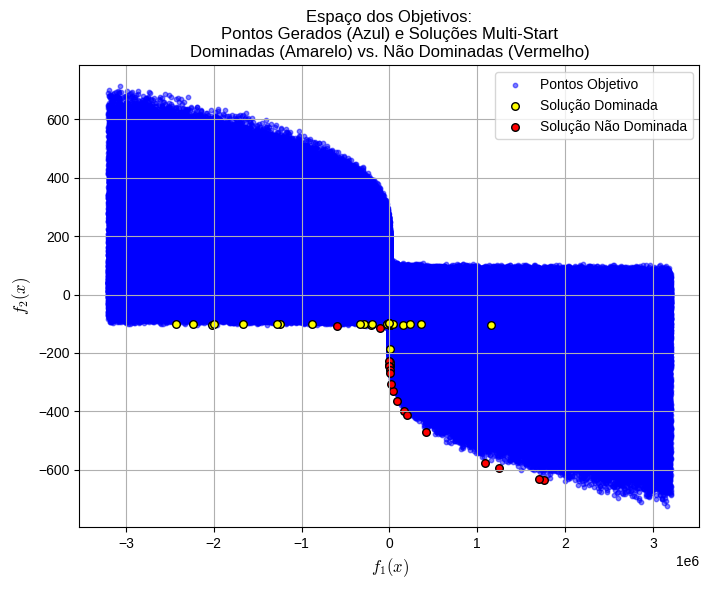

In [3]:
#==========================================================
# Multi-start do problema Das e Dennis (Não convexa)
#=========================================================
!pip install pygmo # Use antes de rodar
import time  # Importa o módulo para medição de tempo
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygmo as pg  # Certifique-se de instalar o PyGMO (pip install pygmo)
from matplotlib.patches import Polygon
np.random.seed(31)
# ——————————————————————————————
# 1) Use MathText sem LaTeX externo, mas com Computer Modern
plt.rcParams['text.usetex']        = False
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.serif']         = ['Computer Modern']
plt.rcParams['mathtext.fontset']   = 'cm'
# ——————————————————————————————
#=======================================
# 1° FUNÇÃO: DAS & DENNIS (não convexa)
#========================================

def F(x):
    """
    Função principal (Das e Dennis – não convexa)
    Entrada: x em R^5
    Saída: [f1, f2]
      f1 = x[0]² + x[1]² + x[2]³ + x[3]² + x[4]⁵
      f2 = 3*x[0] + 2*x[1] - (x[2]/3) + 0.01*(x[3] - x[4])³
    """
    f1 = x[0]**2 + x[1]**2 + x[2]**3 + x[3]**2 + x[4]**5
    f2 = 3*x[0] + 2*x[1] - (x[2]/3) + 0.01*(x[3] - x[4])**3
    return [f1, f2]

def Dasdennisgrad(x):
    """
    Gradientes de f1 e f2.
    """
    grad_f1 = np.array([2*x[0], 2*x[1], 3*x[2]**2, 2*x[3], 5*x[4]**4])
    grad_f2 = np.array([3, 2, -1/3, 0.03*(x[3] - x[4])**2, -0.03*(x[3] - x[4])**2])
    return grad_f1, grad_f2

#=============================================
# FUNÇÕES AUXILIARES PARA A BUSCA
#==============================================

def Armijo_tamanho_passo(z, d, F, J, A_k, delta):
    """
    Seleciona tamanho de passo t através do critério de Armijo não-monótono do tipo máximo..
    Parâmetros:
    z : Ponto atual (x,y)
    d : Direção de busca obtida pelo SLSQP
    F : Função objetivo.
    J : Avaliação do gradiente em z na direção d
    A_k : Par (A₁, A₂) acumulado nas últimas iterações.
    delta : Parâmetro usado apenas em Armijo.

    Retorna: O maior tamanho de passo t=1/2^j (j = 0, 1, ...,19) que satisfaz a cond. de Armijo
        F(z + td) ≤ A_k + delta* t *J;
        retorna 1.0 se nenhum j satisfizer.
    """
    for j in range(20):
        t_val = 1/(2**j)
        z_next = z + t_val*d
        F_next = np.array(F(z_next))
        rhs = np.array(A_k) + delta*t_val*J
        if np.all(F_next <= rhs):
            return t_val
    return 1


def compute_A_k(f_values, k, M=10):
    """
    Calcula o valor de A_k para Armijo não-monótono.

    Parâmetros usados:
    f_values : Histórico de valores de F(z) (cada um sendo um vetor de dimensão 2).
    k : índice da iteração atual.
    M : Número máximo de iterações consideradas em A_k (M=10).

    Retorna:
    A_k : Par (A₁, A₂), onde cada componente é o máximo de F_j nas últimas min(k, M) iterações.
    """
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k) : k+1] #Seleciona o conjunto de valores F(z^j) desde j = k–m_k até j = k
    if not recentes:  # Caso k=0 e f_values tem só um elemento
        return f_values[-1]
    A1 = max(f[0] for f in recentes)
    A2 = max(f[1] for f in recentes)
    return (A1, A2)


def projecao_caixa(x, bounds):
    """
    Projeta x na caixa definida por bounds.
    """
    lower = np.array([b[0] for b in bounds])
    upper = np.array([b[1] for b in bounds])
    return np.clip(x, lower, upper)

# ======================================================================
# Busca da direção por função suave
# ======================================================================
def buscadirecao(x, bounds, tol_slsqp=1e-10):

    g1, g2 = Dasdennisgrad(x)

    dt0 = np.concatenate([np.zeros_like(x), [0.0]])  # ponto inicial na busca de direção

    # objetivo
    obj        = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad   = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrições do epígrafe
    cons = [
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g1, dt[:-1])},
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g2, dt[:-1])},
    ]

    # caixa para garantir x+d dentro dos bounds
    for i,(lo,up) in enumerate(bounds):
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,up=up:  up - (x[i] + dt[i])})
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,lo=lo: (x[i] + dt[i]) - lo})

    res = minimize(obj, dt0, jac=obj_grad, constraints=cons,
                   method='SLSQP',
                   options={'ftol':tol_slsqp,'maxiter':500,'disp':False})

    d_opt = res.x[:-1]
    t_opt = res.x[-1]
    phi   = obj(res.x)
    return d_opt, t_opt, phi
#======================================================================
# PARÂMETROS GERAIS
#=======================================================================

bounds = [(-20, 20), (-20, 20), (-20, 20), (-20, 20), (-20, 20)]
#=========================================================
# algoritmo principal
# ==========================================================
def PGMMOP(x0, max_iter=50, M=10, delta=0.5,
                     tol_inner=1e-8, bounds=bounds):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      gamma_hist – histórico de phi(d^k)
    """
    x = x0.copy()
    f_vals, gamma_hist = [], []

    for k in range(max_iter):
        Fx = F(x)
        f_vals.append(Fx)

        # Chama a função que encontra a direção
        d, t, phi_val = buscadirecao(x, bounds)
        gamma_hist.append(phi_val)

        # critério de parada
        if np.linalg.norm(d) <= tol_inner:
            break
        A_k = compute_A_k(f_vals, k, M)
        J    = Dasdennisgrad(x)
        Jd   = np.array([np.dot(J[0], d), np.dot(J[1], d)])
        t    = Armijo_tamanho_passo(x, d, F, Jd, A_k, delta)


        x = projecao_caixa(x + t*d, bounds) #Atualização

    return x, d, k, phi_val, F(x), gamma_hist


import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#==================================
# LOOP DO MULTI-START
#===============================

num_starts = 50  # Quantidade de pontos iniciais a serem testados
solucoes = []          # Armazena os pontos ótimos x*
solucoes_imagens = []    # Armazena F(x*) para cada partida
all_details = []        # Para guardar detalhes (ponto inicial, x*, dk, iterações, final_phi, F(x*))

initial_points = []

# Registra o tempo de início do multi-start
start_time = time.time()

for i in range(num_starts):
    # Geração de um ponto inicial aleatório dentro dos bounds
    x_ini = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
    x_ini = projecao_caixa(x_ini, bounds)
    initial_points.append(x_ini)

print("===== Resultados Multi-Start =====")
for i, x0 in enumerate(initial_points):
    x_opt, subproblem_vec, iters, final_phi, Fx, gamma_historico = PGMMOP(x0)
    solucoes.append(x_opt)
    solucoes_imagens.append(Fx)
    all_details.append((x0, x_opt, subproblem_vec, iters, final_phi, Fx))
    print(f"\n--- Início {i+1} ---")
    print("Ponto inicial (após projeção):", x0)
    print("Ponto ótimo x*:", x_opt)
    print("Vetor do subproblema final:", subproblem_vec)
    print("Número de iterações:", iters)
    print("Valor final de φ:", final_phi)
    print("Imagem da solução ótima F(x*):", Fx)

# Registra o tempo final e calcula a diferença
end_time = time.time()
print("\nTempo de execução do multi-start: {:.4f} segundos".format(end_time - start_time))

#================================================
# GERAÇÃO DOS PONTOS PARA O ESPAÇO DOS OBJETIVOS
#===============================================

num_pontos = 2000000  # Quantidade de pontos a serem gerados na caixa
amostras = np.random.uniform(
    [b[0] for b in bounds],
    [b[1] for b in bounds],
    size=(num_pontos, len(bounds))
)
# Mapeamento para o espaço dos objetivos
objetivo_valor = np.array([F(amostra) for amostra in amostras])
f1_valor = objetivo_valor[:, 0]
f2_valor = objetivo_valor[:, 1]

#=================================
# Filtro de dominância
#=================================

def domina(sol1, sol2):
    """
    Retorna True se sol1 domina sol2:
    sol1 é <= sol2 em todas as componentes e
    sol1 é < sol2 em pelo menos uma componente
    """
    sol1, sol2 = np.array(sol1), np.array(sol2)
    return np.all(sol1 <= sol2) and np.any(sol1 < sol2)


solu_dominada, solu_naodominada = [], [] # Para separar as soluções encontradas em "dominadas" e "não dominadas"
for sol in solucoes_imagens: # percorre cada solução candidata
    dominado = False                      # assume que ainda não foi dominada
     # verifica dominância entre as próprias soluções do algoritmo
    for outro in solucoes_imagens:
        if not np.array_equal(sol, outro) and domina(outro, sol):
            dominado = True           # achou alguém que domina
            break                    # pode sair do processo interno
    #Aqui se ainda não foi dominado, vamos verificar contra todos os pontos gerados
    if not dominado:
        cond_all = np.all(objetivo_valor <= sol, axis=1) # verifica se cada valor objetivo <= 'sol' em todas as componentes. Devolve um vetor
        cond_any = np.any(objetivo_valor < sol, axis=1)  # O "objetivo_valor <= sol" é uma matriz de boolerianos n°pontos x 2 (f1,f2) e axis=1 é para operar ao longo das colunas, verifica f_1_1<=f_sol,f_1_2<=f_sol_1... e depois para f
        dominado = np.any(cond_all & cond_any)           # Faz o AND entre os vetores boolerianos
    if dominado:
      #coloca a solução na lista de dominado
       solu_dominada.append(sol)
    else:
      # coloca na lista de não dominado
      solu_naodominada.append(sol)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#========================================================
# PLOT DO ESPAÇO DOS OBJETIVOS E DAS SOLUÇÕES
#=========================================================
#Plot da figura
plt.figure(figsize=(8, 6))

# Pontos dos pontos gerados (em azul)
plt.scatter(f1_valor, f2_valor, alpha=0.5, s=10, marker='o', color="blue", label="Pontos Objetivo")

# Soluções dominadas (amarelo)
for sol in solu_dominada:
    plt.scatter(sol[0], sol[1], color="yellow", s=30, marker='o', edgecolor="black",
                label="Solução Dominada" if "Solução Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

# Soluções não dominadas (vermelho)
for sol in solu_naodominada:
    plt.scatter(sol[0], sol[1], color="red", s=30, marker='o', edgecolor="black",
                label="Solução Não Dominada" if "Solução Não Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Espaço dos Objetivos:\nPontos Gerados (Azul) e Soluções Multi-Start\nDominadas (Amarelo) vs. Não Dominadas (Vermelho)", fontsize=12)
plt.xlabel(r"$f_1(x)$", fontsize=12)
plt.ylabel(r"$f_2(x)$", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

===== Resultados Multi-Start =====

--- Início 1 ---
Ponto inicial (após projeção): [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544]
Ponto ótimo x*: [0.24953446 0.24955266 0.24954575 0.24954154 0.24952755]
Vetor do subproblema final: [0. 0. 0. 0. 0.]
Número de iterações: 23
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64(0.06227040799637325), np.float64(3.0641088345406047)]

--- Início 2 ---
Ponto inicial (após projeção): [-1.37602192 -1.76766555  1.46470458  0.40446005  0.83229031]
Ponto ótimo x*: [-1.08709585e-05 -1.39650528e-05  1.15715766e-05  3.19534765e-06
  6.57532674e-06]
Vetor do subproblema final: [0. 0. 0. 0. 0.]
Número de iterações: 23
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64(1.0010939829361772e-10), np.float64(4.0000027951083075)]

--- Início 3 ---
Ponto inicial (após projeção): [-1.91766202  1.87963941  1.32977056 -1.15064356 -1.27270013]
Ponto ótimo x*: [-9.08844769e-06  8.90824551e-06  6.30223151e-06 -5.45328835e-06


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


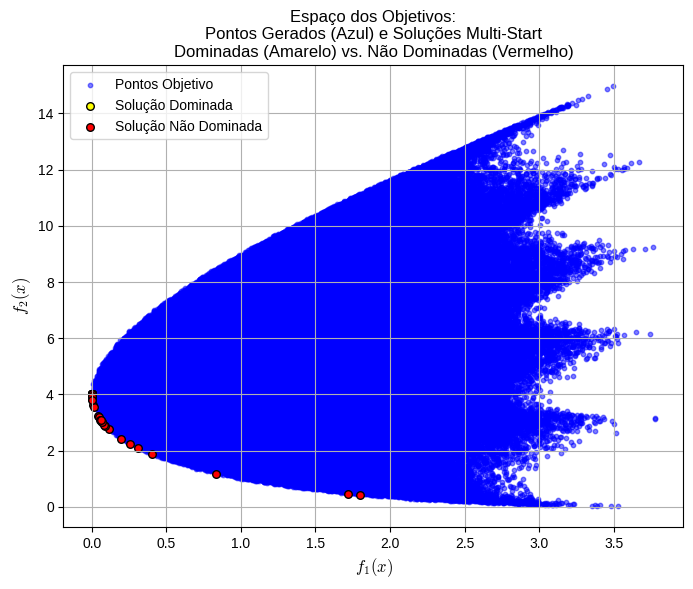

In [2]:
#==========================================================
# Multi-start do problema JOS-1 ( convexa)
#=========================================================
#!pip install pygmo # Use antes de rodar
import time  # Importa o módulo para medição de tempo
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygmo as pg  # Certifique-se de instalar o PyGMO (pip install pygmo)
from matplotlib.patches import Polygon
np.random.seed(42)
#
# 1) Use MathText sem LaTeX externo, mas com Computer Modern
plt.rcParams['text.usetex']        = False
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.serif']         = ['Computer Modern']
plt.rcParams['mathtext.fontset']   = 'cm'

#=======================================
# 2° FUNÇÃO: JOS1 (convexa)
#========================================

def F(x):
    """f(x) = [(1/5)∑x_i² , (1/5)∑(x_i-2)²]"""
    return [
        0.2*np.sum(x**2),
        0.2*np.sum((x-2)**2)
    ]

def JOS_grad(x):
    """∇f₁ , ∇f₂"""
    g1 = 0.4 * x
    g2 = 0.4 * (x - 2)
    return g1, g2

#=============================================
# FUNÇÕES AUXILIARES PARA A BUSCA (φ, etc.)
#==============================================

def Armijo_tamanho_passo(z, d, F, J, A_k, delta):
    """
    Seleciona tamanho de passo t através do critério de Armijo não-monótono do tipo máximo..
    Parâmetros:
    z : Ponto atual (x,y)
    d : Direção de busca obtida pelo SLSQP
    F : Função objetivo.
    J : Avaliação do gradiente em z na direção d.
    A_k : Par (A₁, A₂) acumulado nas últimas iterações.
    delta : Parâmetro usado apenas em Armijo.

    Retorna: O maior tamanho de passo t=1/2^j (j = 0, 1, ...,20) que satisfaz a cond. de Armijo
        F(z + td) ≤ A_k + δ t J;
        retorna 1.0 se nenhum j satisfizer.
    """
    for j in range(20):
        t_val = 1/(2**j)
        z_next = z + t_val*d
        F_next = np.array(F(z_next))
        rhs = np.array(A_k) + delta*t_val*J
        if np.all(F_next <= rhs):
            return t_val
    return 1


def compute_A_k(f_values, k, M=10):
    """
    Calcula o valor de A_k para Armijo não-monótono.

    Parâmetros usados:
    f_values : Histórico de valores de F(z) (cada um sendo um vetor de dimensão 2).
    k : índice da iteração atual.
    M : Número máximo de iterações consideradas em A_k (M=10).

    Retorna:
    A_k : Par (A₁, A₂), onde cada componente é o máximo de F_j nas últimas min(k, M) iterações.
    """
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k) : k+1] #Seleciona o conjunto de valores F(z^j) desde j = k–m_k até j = k
    if not recentes:  # Caso k=0 e f_values tem só um elemento
        return f_values[-1]
    A1 = max(f[0] for f in recentes)
    A2 = max(f[1] for f in recentes)
    return (A1, A2)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']


def projecao_caixa(x, bounds):
    """
    Projeta x na caixa definida por bounds.
    """
    lower = np.array([b[0] for b in bounds])
    upper = np.array([b[1] for b in bounds])
    return np.clip(x, lower, upper)

# ======================================================================
# FUNÇÃO  de DIREÇÃO  (sub-problema suave com variável auxiliar t)
# ======================================================================
def buscadirecao(x, bounds, tol_slsqp=1e-10):
    """

    """
    g1, g2 = JOS_grad(x)

    dt0 = np.concatenate([np.zeros_like(x), [0.0]])  # ponto inicial na busca de direção

    # objetivo
    obj        = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad   = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrições do epígrafe
    cons = [
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g1, dt[:-1])},
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g2, dt[:-1])},
    ]

    # caixa para garantir x+d dentro dos bounds
    for i,(lo,up) in enumerate(bounds):
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,up=up:  up - (x[i] + dt[i])})
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,lo=lo: (x[i] + dt[i]) - lo})

    res = minimize(obj, dt0, jac=obj_grad, constraints=cons,
                   method='SLSQP',
                   options={'ftol':tol_slsqp,'maxiter':500,'disp':False})

    d_opt = res.x[:-1]
    t_opt = res.x[-1]
    phi   = obj(res.x)
    return d_opt, t_opt, phi
#======================================================================
# PARÂMETROS GERAIS
#=======================================================================

bounds     = [(-2,2)]*5          # caixa em R⁵
#=========================================================
# algoritmo principal
# ==========================================================
def PGMMOP(x0, max_iter=50, M=10, delta=0.5,
                     tol_inner=1e-8, bounds=bounds):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – φ final
      F(x*)      – imagem final
      gamma_hist – histórico de φ(d^k)
    """
    x = x0.copy()
    f_vals, gamma_hist = [], []

    for k in range(max_iter):
        Fx = F(x)
        f_vals.append(Fx)

        # Chama a função que encontra a direção
        d, t, phi_val = buscadirecao(x, bounds)
        gamma_hist.append(phi_val)

        # ---- critério de parada:  ‖d‖ ----
        if np.linalg.norm(d) <= tol_inner:
            break
        A_k = compute_A_k(f_vals, k, M)
        J    = Dasdennisgrad(x)
        Jd   = np.array([np.dot(J[0], d), np.dot(J[1], d)])
        t    = Armijo_tamanho_passo(x, d, F, Jd, A_k, delta)


        x = projecao_caixa(x + t*d, bounds) #Atualização

    return x, d, k, phi_val, F(x), gamma_hist


import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#==================================
# LOOP DO MULTI-START
#===============================

num_starts = 50  # Quantidade de pontos iniciais a serem testados
solucoes = []          # Armazena os pontos ótimos x*
solucoes_imagens = []    # Armazena F(x*) para cada partida
all_details = []        # Para guardar detalhes (ponto inicial, x*, dk, iterações, final_phi, F(x*))

initial_points = []

# Registra o tempo de início do multi-start
start_time = time.time()

for i in range(num_starts):
    # Geração de um ponto inicial aleatório dentro dos bounds
    x_ini = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
    x_ini = projecao_caixa(x_ini, bounds)
    initial_points.append(x_ini)

print("===== Resultados Multi-Start =====")
for i, x0 in enumerate(initial_points):
    x_opt, subproblem_vec, iters, final_phi, Fx, gamma_historico = PGMMOP(x0)
    solucoes.append(x_opt)
    solucoes_imagens.append(Fx)
    all_details.append((x0, x_opt, subproblem_vec, iters, final_phi, Fx))
    print(f"\n--- Início {i+1} ---")
    print("Ponto inicial (após projeção):", x0)
    print("Ponto ótimo x*:", x_opt)
    print("Vetor do subproblema final:", subproblem_vec)
    print("Número de iterações:", iters)
    print("Valor final de φ:", final_phi)
    print("Imagem da solução ótima F(x*):", Fx)

# Registra o tempo final e calcula a diferença
end_time = time.time()
print("\nTempo de execução do multi-start: {:.4f} segundos".format(end_time - start_time))

#================================================
# GERAÇÃO DOS PONTOS PARA O ESPAÇO DOS OBJETIVOS
#===============================================

num_pontos = 1000000  # Quantidade de pontos a serem gerados na caixa
samples = np.random.uniform(
    [b[0] for b in bounds],
    [b[1] for b in bounds],
    size=(num_pontos, len(bounds))
)
# Mapeamento para o espaço dos objetivos
objetivo_valor = np.array([F(sample) for sample in samples])
f1_valor = objetivo_valor[:, 0]
f2_valor = objetivo_valor[:, 1]

#=================================
# Filtro de dominância
#=================================

def domina(sol1, sol2):
    """
    Retorna True se sol1 domina sol2:
    sol1 é <= sol2 em todas as componentes e
    sol1 é < sol2 em pelo menos uma componente
    """
    sol1, sol2 = np.array(sol1), np.array(sol2)
    return np.all(sol1 <= sol2) and np.any(sol1 < sol2)


solu_dominada, solu_naodominada = [], [] # Para separar as soluções encontradas em "dominadas" e "não dominadas"
for sol in solucoes_imagens: # percorre cada solução candidata
    dominado = False                      # assume que ainda não foi dominada
     # verifica dominância entre as próprias soluções do algoritmo
    for outro in solucoes_imagens:
        if not np.array_equal(sol, outro) and domina(outro, sol):
            dominado = True           # achou alguém que domina
            break                    # pode sair do processo interno
    #Aqui se ainda não foi dominado, vamos verificar contra todos os pontos gerados
    if not dominado:
        cond_all = np.all(objetivo_valor <= sol, axis=1) # verifica se cada valor objetivo <= 'sol' em todas as componentes. Devolve um vetor
        cond_any = np.any(objetivo_valor < sol, axis=1)  # O "objetivo_valor <= sol" é uma matriz de boolerianos n°pontos x 2 (f1,f2) e axis=1 é para operar ao longo das colunas, verifica f_1_1<=f_sol,f_1_2<=f_sol_1... e depois para f
        dominado = np.any(cond_all & cond_any)           # Faz o AND entre os vetores boolerianos
    if dominado:
      #coloca a solução na lista de dominado
       solu_dominada.append(sol)
    else:
      # coloca na lista de não dominado
      solu_naodominada.append(sol)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']


#========================================================
# PLOT DO ESPAÇO DOS OBJETIVOS E DAS SOLUÇÕES
#=========================================================
#Plot da figura
plt.figure(figsize=(8, 6))

# Pontos dos pontos gerados (em azul)
plt.scatter(f1_valor, f2_valor, alpha=0.5, s=10, marker='o', color="blue", label="Pontos Objetivo")

# Soluções dominadas (amarelo)
for sol in solu_dominada:
    plt.scatter(sol[0], sol[1], color="yellow", s=30, marker='o', edgecolor="black",
                label="Solução Dominada" if "Solução Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

# Soluções não dominadas (vermelho)
for sol in solu_naodominada:
    plt.scatter(sol[0], sol[1], color="red", s=30, marker='o', edgecolor="black",
                label="Solução Não Dominada" if "Solução Não Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Espaço dos Objetivos:\nPontos Gerados (Azul) e Soluções Multi-Start\nDominadas (Amarelo) vs. Não Dominadas (Vermelho)", fontsize=12)
plt.xlabel(r"$f_1(x)$", fontsize=12)
plt.ylabel(r"$f_2(x)$", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

===== Resultados Multi-Start =====

--- Início 1 ---
Ponto inicial (após projeção): [1.74908024 2.92184342 2.57499963 2.19731697]
Ponto ótimo x*: [1.81212386 2.56273954 2.56273727 2.56267911]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 41
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64(13.43544566740928), np.float64(4.091458081369064)]

--- Início 2 ---
Ponto inicial (após projeção): [1.31203728 1.66158756 1.50632177 2.73235229]
Ponto ótimo x*: [1.30021535 1.83877947 1.83877947 1.83879897]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 21
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64(9.640083404201203), np.float64(5.702291198581334)]

--- Início 3 ---
Ponto inicial (após projeção): [2.20223002 2.53706545 1.44685617 2.9398197 ]
Ponto ótimo x*: [1.68617235 2.38460157 2.38460109 2.38464781]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 37
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64

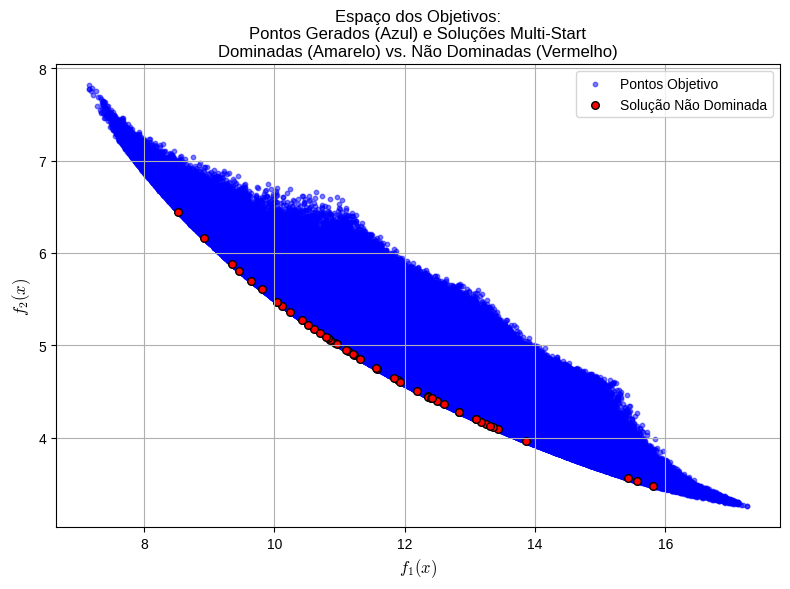

In [21]:
#==========================================================
# Multi-start do problema STADLER-DAUER (convexa)
#=========================================================
#!pip install pygmo # Use antes de rodar
import time  # Importa o módulo para medição de tempo
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygmo as pg  # Certifique-se de instalar o PyGMO (pip install pygmo)
from matplotlib.patches import Polygon
np.random.seed(42)

# 1) Use MathText sem LaTeX externo, mas com Computer Modern
plt.rcParams['text.usetex']        = False
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.serif']         = ['Computer Modern']
plt.rcParams['mathtext.fontset']   = 'cm'

#=======================================
# 1° FUNÇÃO: STADLER-DAUER (convexa)
#========================================

SQ2 = np.sqrt(2)

def F(x):
    """
    Função principal (Stadler-Dauer – convexa)
    Entrada: x ∈ R⁴
    Saída  : [f1, f2]
      f1 = 2·x0 + √2·x1 + √2·x2 + x3
      f2 = 2/x0 + 2√2/x1 + 2√2/x2 + 2/x3
    """
    f1 = 2*x[0] + SQ2*x[1] + SQ2*x[2] + x[3]
    f2 = 2/x[0] + 2*SQ2/x[1] + 2*SQ2/x[2] + 2/x[3]
    return [f1, f2]

def SD_grad(x):
    """Gradientes de f1 e f2."""
    g1 = np.array([2, SQ2, SQ2, 1])
    g2 = np.array([
        -2/(x[0]**2),
        -2*SQ2/(x[1]**2),
        -2*SQ2/(x[2]**2),
        -2/(x[3]**2)
    ])
    return g1, g2

#=============================================
# FUNÇÕES AUXILIARES PARA A BUSCA
#=============================================

def Armijo_tamanho_passo(z, d, F_fun, Jd, A_k, delta):
    """Critério de Armijo não-monótono (máximo)."""
    for j in range(20):
        t_val = 1/(2**j)
        if np.all(np.array(F_fun(z + t_val*d)) <= np.array(A_k) + delta*t_val*Jd):
            return t_val
    return 1.0

def compute_A_k(f_values, k, M=10):
    """Calcula A_k para Armijo não-monótono."""
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k):k+1]
    if not recentes:
        return f_values[-1]
    A1 = max(v[0] for v in recentes)
    A2 = max(v[1] for v in recentes)
    return (A1, A2)

def projecao_caixa(x, bounds):
    """Projeta x na caixa *bounds*."""
    lo = np.array([b[0] for b in bounds])
    up = np.array([b[1] for b in bounds])
    return np.clip(x, lo, up)

# ======================================================================
# Busca da direção por função suave (sub-problema do epígrafe)
# ======================================================================

def buscadirecao(x, bounds, tol_slsqp=1e-10):
    g1, g2 = SD_grad(x)
    dt0 = np.concatenate([np.zeros_like(x), [0.0]])

    obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    cons = [
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g1, dt[:-1])},
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g2, dt[:-1])},
    ]
    for i,(lo,up) in enumerate(bounds):
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,up=up:  up - (x[i]+dt[i])})
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,lo=lo: (x[i]+dt[i]) - lo})

    res = minimize(obj, dt0, jac=obj_grad,
                   constraints=cons, method='SLSQP',
                   options={'ftol': tol_slsqp, 'maxiter': 500, 'disp': False})

    d_opt = res.x[:-1]
    t_opt = res.x[-1]
    phi   = obj(res.x)
    return d_opt, t_opt, phi

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#======================================================================
# PARÂMETROS GERAIS
#======================================================================

bounds = [(1,3), (SQ2,3), (SQ2,3), (1,3)]

#=========================================================
# Algoritmo principal (PGMMOP)
#=========================================================

def PGMMOP(x0, max_iter=50, M=10, delta=0.5,
           tol_inner=1e-8, bounds=bounds):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      gamma_hist – histórico de phi(d^k)
    """
    x = x0.copy()
    f_vals, gamma_hist = [], []

    for k in range(max_iter):
        Fx = F(x)
        f_vals.append(Fx)

        d, _, phi_val = buscadirecao(x, bounds)
        gamma_hist.append(phi_val)

        if np.linalg.norm(d) <= tol_inner:
            break

        A_k = compute_A_k(f_vals, k, M)
        g1, g2 = SD_grad(x)
        Jd = np.array([np.dot(g1, d), np.dot(g2, d)])
        t  = Armijo_tamanho_passo(x, d, F, Jd, A_k, delta)
        x  = projecao_caixa(x + t*d, bounds)

    return x, d, k, phi_val, F(x), gamma_hist

#==================================
# LOOP DO MULTI-START
#==================================

num_starts = 50
solucoes, solucoes_imagens, all_details = [], [], []
initial_points = []

start_time = time.time()

for i in range(num_starts):
    x_ini = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
    x_ini = projecao_caixa(x_ini, bounds)
    initial_points.append(x_ini)

print("===== Resultados Multi-Start =====")
for i, x0 in enumerate(initial_points):
    x_opt, d_last, iters, phi_fin, Fx, gamma_hist = PGMMOP(x0)
    solucoes.append(x_opt)
    solucoes_imagens.append(Fx)
    all_details.append((x0, x_opt, d_last, iters, phi_fin, Fx))

    print(f"\n--- Início {i+1} ---")
    print("Ponto inicial (após projeção):", x0)
    print("Ponto ótimo x*:", x_opt)
    print("Vetor do subproblema final:", d_last)
    print("Número de iterações:", iters)
    print("Valor final de φ:", phi_fin)
    print("Imagem da solução ótima F(x*):", Fx)

end_time = time.time()
print("\nTempo de execução do multi-start: {:.4f} segundos".format(end_time - start_time))

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#================================================
# GERAÇÃO DOS PONTOS PARA O ESPAÇO DOS OBJETIVOS
#================================================

num_pontos = 1_000_000
samples = np.column_stack([
    np.random.uniform(lo, up, num_pontos) for lo, up in bounds
])
objetivo_valor = np.array([F(s) for s in samples])

f1_valor = objetivo_valor[:, 0]
f2_valor = objetivo_valor[:, 1]

#=================================
# Filtro de dominância
#=================================

def domina(sol1, sol2):
    """
    Retorna True se sol1 domina sol2:
    sol1 é <= sol2 em todas as componentes e
    sol1 é < sol2 em pelo menos uma componente
    """
    sol1, sol2 = np.array(sol1), np.array(sol2)
    return np.all(sol1 <= sol2) and np.any(sol1 < sol2)


solu_dominada, solu_naodominada = [], [] # Para separar as soluções encontradas em "dominadas" e "não dominadas"
for sol in solucoes_imagens: # percorre cada solução candidata
    dominado = False                      # assume que ainda não foi dominada
     # verifica dominância entre as próprias soluções do algoritmo
    for outro in solucoes_imagens:
        if not np.array_equal(sol, outro) and domina(outro, sol):
            dominado = True           # achou alguém que domina
            break                    # pode sair do processo interno
    #Aqui se ainda não foi dominado, vamos verificar contra todos os pontos gerados
    if not dominado:
        cond_all = np.all(objetivo_valor <= sol, axis=1) # verifica se cada valor objetivo <= 'sol' em todas as componentes. Devolve um vetor
        cond_any = np.any(objetivo_valor < sol, axis=1)  # O "objetivo_valor <= sol" é uma matriz de boolerianos n°pontos x 2 (f1,f2) e axis=1 é para operar ao longo das colunas, verifica f_1_1<=f_sol,f_1_2<=f_sol_1... e depois para f
        dominado = np.any(cond_all & cond_any)           # Faz o AND entre os vetores boolerianos
    if dominado:
      #coloca a solução na lista de dominado
       solu_dominada.append(sol)
    else:
      # coloca na lista de não dominado
      solu_naodominada.append(sol)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#========================================================
# PLOT DO ESPAÇO DOS OBJETIVOS E DAS SOLUÇÕES
#========================================================

plt.figure(figsize=(8, 6))
plt.scatter(f1_valor, f2_valor, alpha=0.5, s=10, marker='o', color='blue', label='Pontos Objetivo')

for sol in solu_dominada:
    plt.scatter(sol[0], sol[1], color='yellow', s=30, marker='o', edgecolor='black',
                label='Solução Dominada' if 'Solução Dominada' not in plt.gca().get_legend_handles_labels()[1] else '')

for sol in solu_naodominada:
    plt.scatter(sol[0], sol[1], color='red', s=30, marker='o', edgecolor='black',
                label='Solução Não Dominada' if 'Solução Não Dominada' not in plt.gca().get_legend_handles_labels()[1] else '')

plt.title('Espaço dos Objetivos:\nPontos Gerados (Azul) e Soluções Multi-Start\nDominadas (Amarelo) vs. Não Dominadas (Vermelho)', fontsize=12)
plt.xlabel(r'$f_1(x)$', fontsize=12)
plt.ylabel(r'$f_2(x)$', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

===== Resultados Multi-Start =====

--- Início 1 ---
Ponto inicial (após projeção): [-0.09231297 -0.44463396  0.28853488 -0.21269482]
Ponto ótimo x*: [ 0.11030586 -0.33441566  0.23534217 -0.17323364]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 11
Valor final de φ: 0.0
Imagem da solução ótima F(x*): [np.float64(1.110674851462503e-11), np.float64(0.2948716450271888)]

--- Início 2 ---
Ponto inicial (após projeção): [-0.04964941 -0.19608769  0.02639952  0.12381221]
Ponto ótimo x*: [ 0.01699185 -0.14002842  0.02419945  0.11352175]
Vetor do subproblema final: [ 3.82726101e-04  5.52824393e-05 -9.58420007e-06 -4.48680981e-05]
Número de iterações: 49
Valor final de φ: -7.582023252573365e-08
Imagem da solução ótima F(x*): [np.float64(3.4180402897052593e-08), np.float64(0.030908801013379842)]

--- Início 3 ---
Ponto inicial (após projeção): [0.27677546 0.18624165 0.48093886 0.10081609]
Ponto ótimo x*: [0.25359396 0.21214831 0.4658704  0.09754081]
Vetor do subproblema final: [0

/tmp/ipython-input-22-3134099379.py:266: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


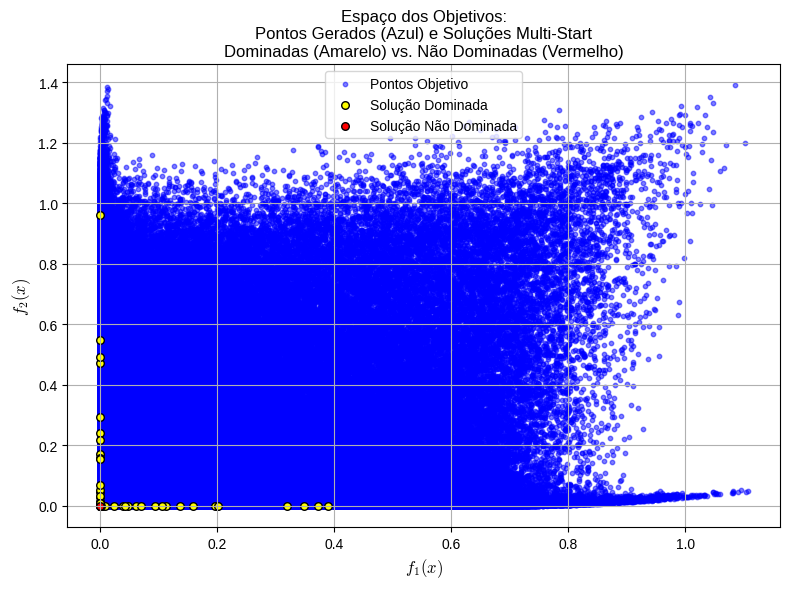

In [22]:
#==========================================================
# Multi-start do problema Trigonometric (não convexa)
#=========================================================
#!pip install pygmo # Use antes de rodar
import time  # Importa o módulo para medição de tempo
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygmo as pg  # Certifique-se de instalar o PyGMO (pip install pygmo)
from matplotlib.patches import Polygon
np.random.seed(40)

# 1) Use MathText sem LaTeX externo, mas com Computer Modern
plt.rcParams['text.usetex']        = False
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.serif']         = ['Computer Modern']
plt.rcParams['mathtext.fontset']   = 'cm'

#=======================================
#  FUNÇÃO: Trigonometric (não convexa)
#========================================

def F(x):
    """
    Função principal Trigonometric
    Entrada: x em R^4
    Saída: [f1, f2]
      f1 = (4 - sum(cos(x)) + 1*(1 - cos(x[0])) - sin(x[0]))^2
      f2 = (4 - sum(cos(x)) + 2*(1 - cos(x[1])) - sin(x[1]))^2
    """
    A1 = 4 - np.sum(np.cos(x)) + 1 * (1 - np.cos(x[0])) - np.sin(x[0])
    A2 = 4 - np.sum(np.cos(x)) + 2 * (1 - np.cos(x[1])) - np.sin(x[1])
    f1 = A1**2
    f2 = A2**2
    return [f1, f2]

def Trigonometricgrad(x):
    """
    Gradientes de f1 e f2.
    """
    grad_f1 = np.zeros_like(x)
    grad_f2 = np.zeros_like(x)

    A1 = 4 - np.sum(np.cos(x)) + 1 * (1 - np.cos(x[0])) - np.sin(x[0])
    A2 = 4 - np.sum(np.cos(x)) + 2 * (1 - np.cos(x[1])) - np.sin(x[1])

    for k in range(len(x)):
        if k == 0:
            grad_f1[k] = 2 * A1 * (2 * np.sin(x[0]) - np.cos(x[0]))
        else:
            grad_f1[k] = 2 * A1 * np.sin(x[k])

        if k == 1:
            grad_f2[k] = 2 * A2 * (3 * np.sin(x[1]) - np.cos(x[1]))
        else:
            grad_f2[k] = 2 * A2 * np.sin(x[k])

    return grad_f1, grad_f2

#=============================================
# FUNÇÕES AUXILIARES PARA A BUSCA
#=============================================

def Armijo_tamanho_passo(z, d, F_fun, Jd, A_k, delta):
    """Critério de Armijo não-monótono (máximo)."""
    for j in range(20):
        t_val = 1/(2**j)
        if np.all(np.array(F_fun(z + t_val*d)) <= np.array(A_k) + delta*t_val*Jd):
            return t_val
    return 1.0

def compute_A_k(f_values, k, M=10):
    """Calcula A_k para Armijo não-monótono."""
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k):k+1]
    if not recentes:
        return f_values[-1]
    A1 = max(v[0] for v in recentes)
    A2 = max(v[1] for v in recentes)
    return (A1, A2)

def projecao_caixa(x, bounds):
    """Projeta x na caixa *bounds*."""
    lo = np.array([b[0] for b in bounds])
    up = np.array([b[1] for b in bounds])
    return np.clip(x, lo, up)

# ======================================================================
# Busca da direção por função suave (sub-problema do epígrafe)
# ======================================================================

def buscadirecao(x, bounds, tol_slsqp=1e-10):
    g1, g2 = Trigonometricgrad(x)
    dt0 = np.concatenate([np.zeros_like(x), [0.0]])

    obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    cons = [
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g1, dt[:-1])},
        {'type':'ineq', 'fun': lambda dt: dt[-1] - np.dot(g2, dt[:-1])},
    ]
    for i,(lo,up) in enumerate(bounds):
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,up=up:  up - (x[i]+dt[i])})
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,lo=lo: (x[i]+dt[i]) - lo})

    res = minimize(obj, dt0, jac=obj_grad,
                   constraints=cons, method='SLSQP',
                   options={'ftol': tol_slsqp, 'maxiter': 500, 'disp': False})

    d_opt = res.x[:-1]
    t_opt = res.x[-1]
    phi   = obj(res.x)
    return d_opt, t_opt, phi

#======================================================================
# PARÂMETROS GERAIS
#======================================================================

bounds = [(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
#=========================================================
# Algoritmo principal (PGMMOP)
#=========================================================

def PGMMOP(x0, max_iter=50, M=10, delta=0.5,
           tol_inner=1e-8, bounds=bounds):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      gamma_hist – histórico de phi(d^k)
    """
    x = x0.copy()
    f_vals, gamma_hist = [], []

    for k in range(max_iter):
        Fx = F(x)
        f_vals.append(Fx)

        d, _, phi_val = buscadirecao(x, bounds)
        gamma_hist.append(phi_val)

        if np.linalg.norm(d) <= tol_inner:
            break

        A_k = compute_A_k(f_vals, k, M)
        g1, g2 = Trigonometricgrad(x)
        Jd = np.array([np.dot(g1, d), np.dot(g2, d)])
        t  = Armijo_tamanho_passo(x, d, F, Jd, A_k, delta)
        x  = projecao_caixa(x + t*d, bounds)

    return x, d, k, phi_val, F(x), gamma_hist

#==================================
# LOOP DO MULTI-START
#==================================

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

num_starts = 50
solucoes, solucoes_imagens, all_details = [], [], []
initial_points = []

start_time = time.time()

for i in range(num_starts):
    x_ini = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
    x_ini = projecao_caixa(x_ini, bounds)
    initial_points.append(x_ini)

print("===== Resultados Multi-Start =====")
for i, x0 in enumerate(initial_points):
    x_opt, d_last, iters, phi_fin, Fx, gamma_hist = PGMMOP(x0)
    solucoes.append(x_opt)
    solucoes_imagens.append(Fx)
    all_details.append((x0, x_opt, d_last, iters, phi_fin, Fx))

    print(f"\n--- Início {i+1} ---")
    print("Ponto inicial (após projeção):", x0)
    print("Ponto ótimo x*:", x_opt)
    print("Vetor do subproblema final:", d_last)
    print("Número de iterações:", iters)
    print("Valor final de φ:", phi_fin)
    print("Imagem da solução ótima F(x*):", Fx)

end_time = time.time()
print("\nTempo de execução do multi-start: {:.4f} segundos".format(end_time - start_time))

#================================================
# GERAÇÃO DOS PONTOS PARA O ESPAÇO DOS OBJETIVOS
#================================================

num_pontos = 500000
samples = np.column_stack([
    np.random.uniform(lo, up, num_pontos) for lo, up in bounds
])
objetivo_valor = np.array([F(s) for s in samples])

f1_valor = objetivo_valor[:, 0]
f2_valor = objetivo_valor[:, 1]

#=================================
# Filtro de dominância
#=================================

def domina(sol1, sol2):
    """
    Retorna True se sol1 domina sol2:
    sol1 é <= sol2 em todas as componentes e
    sol1 é < sol2 em pelo menos uma componente
    """
    sol1, sol2 = np.array(sol1), np.array(sol2)
    return np.all(sol1 <= sol2) and np.any(sol1 < sol2)


solu_dominada, solu_naodominada = [], [] # Para separar as soluções encontradas em "dominadas" e "não dominadas"
for sol in solucoes_imagens: # percorre cada solução candidata
    dominado = False                      # assume que ainda não foi dominada
     # verifica dominância entre as próprias soluções do algoritmo
    for outro in solucoes_imagens:
        if not np.array_equal(sol, outro) and domina(outro, sol):
            dominado = True           # achou alguém que domina
            break                    # pode sair do processo interno
    #Aqui se ainda não foi dominado, vamos verificar contra todos os pontos gerados
    if not dominado:
        cond_all = np.all(objetivo_valor <= sol, axis=1) # verifica se cada valor objetivo <= 'sol' em todas as componentes. Devolve um vetor
        cond_any = np.any(objetivo_valor < sol, axis=1)  # O "objetivo_valor <= sol" é uma matriz de boolerianos n°pontos x 2 (f1,f2) e axis=1 é para operar ao longo das colunas, verifica f_1_1<=f_sol,f_1_2<=f_sol_1... e depois para f
        dominado = np.any(cond_all & cond_any)           # Faz o AND entre os vetores boolerianos
    if dominado:
      #coloca a solução na lista de dominado
       solu_dominada.append(sol)
    else:
      # coloca na lista de não dominado
      solu_naodominada.append(sol)


import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#========================================================
# PLOT DO ESPAÇO DOS OBJETIVOS E DAS SOLUÇÕES
#========================================================

plt.figure(figsize=(8, 6))
plt.scatter(f1_valor, f2_valor, alpha=0.5, s=10, marker='o', color='blue', label='Pontos Objetivo')

for sol in solu_dominada:
    plt.scatter(sol[0], sol[1], color='yellow', s=30, marker='o', edgecolor='black',
                label='Solução Dominada' if 'Solução Dominada' not in plt.gca().get_legend_handles_labels()[1] else '')

for sol in solu_naodominada:
    plt.scatter(sol[0], sol[1], color='red', s=30, marker='o', edgecolor='black',
                label='Solução Não Dominada' if 'Solução Não Dominada' not in plt.gca().get_legend_handles_labels()[1] else '')

plt.title('Espaço dos Objetivos:\nPontos Gerados (Azul) e Soluções Multi-Start\nDominadas (Amarelo) vs. Não Dominadas (Vermelho)', fontsize=12)
plt.xlabel(r'$f_1(x)$', fontsize=12)
plt.ylabel(r'$f_2(x)$', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


===== RESULTADOS DO MULTI-START (TRIDIA) =====

— Partida 01 —
x inicial: [0.46702984 0.04723225 0.47268436]
x* obtido: [0.5        0.11562408 0.47268436]
Iterações: 1    φ final: 0.0
F(x*): [1.23259516e-32 1.56424154e+00 1.74874323e-01]

— Partida 02 —
x inicial: [ 0.21481599  0.19772882 -0.2839105 ]
x* obtido: [0.27147041 0.5        0.35051065]
Iterações: 5    φ final: 0.0
F(x*): [0.20890308 0.00368783 1.26550926]

— Partida 03 —
x inicial: [ 0.47627445 -0.49376974 -0.24701764]
x* obtido: [ 0.5        -0.44573481 -0.24701764]
Iterações: 2    φ final: 0.0
F(x*): [0.         4.18029827 1.24595506]

— Partida 04 —
x inicial: [-0.06520847  0.27938292 -0.30231493]
x* obtido: [0.34481497 0.45831003 0.5       ]
Iterações: 7    φ final: 0.0
F(x*): [0.09632958 0.1070178  0.52071682]

— Partida 05 —
x inicial: [ 0.36299324  0.48340068 -0.33615776]
x* obtido: [ 0.36829729  0.5        -0.30221548]
Iterações: 1    φ final: 0.0
F(x*): [0.06938241 0.11195399 5.08729548]

— Partida 06 —
x inicial: 

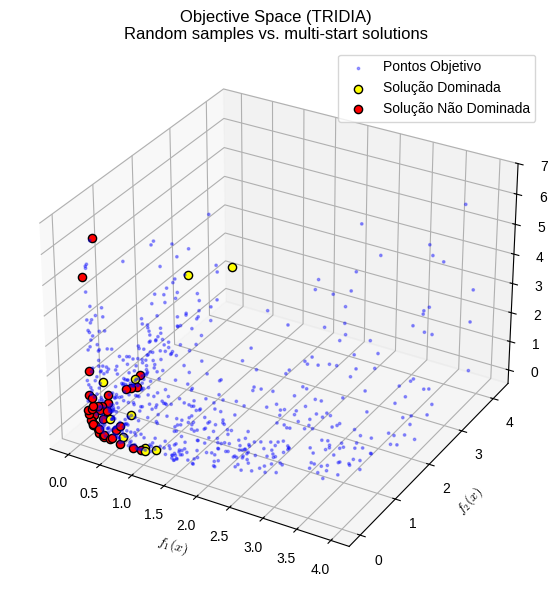

In [16]:
# ==========================================================
#  Multi-start para o problema TRIDIA (convexo, 3 objetivos)
# ==========================================================

import time                      # medição de tempo total
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(4)                # reprodutibilidade


# Configurações de fonte (MathText sem LaTeX externo)
plt.rcParams['text.usetex']      = False
plt.rcParams['font.family']      = 'serif'
plt.rcParams['font.serif']       = ['Computer Modern']
plt.rcParams['mathtext.fontset'] = 'cm'

# ==========================================================
#  1) Definição de F e de seus gradientes
# ==========================================================

def F(x):
    """
    Função TRIDIA (convexa) com 3 componentes:
      f1(x) = (2x0 − 1)²
      f2(x) = 2·(2x0 − x1)²
      f3(x) = 3·(2x1 − x2)²
    """
    f1 = (2*x[0] - 1)**2
    f2 = 2*(2*x[0] - x[1])**2
    f3 = 3*(2*x[1] - x[2])**2
    return np.array([f1, f2, f3])


def TRIDIAgrad(x):
    """
    Retorna (∇f1, ∇f2, ∇f3), cada qual em ℝ³.
    """
    g1 = np.array([4*(2*x[0] - 1),             0,                        0])
    g2 = np.array([8*(2*x[0] - x[1]),  -4*(2*x[0] - x[1]),              0])
    g3 = np.array([          0,       12*(2*x[1] - x[2]),   -6*(2*x[1] - x[2])])
    return g1, g2, g3


# ==========================================================
# 2) Funções auxiliares: Armijo, A_k, projeção, etc.
# ==========================================================

def Armijo_tamanho_passo(z, d, F_fun, slope_vec, A_k, delta):
    """
    Critério de Armijo não-monótono (máximo) em vetor:
      F(z + αd) ≤ A_k + δ α slope_vec
    Busca α = 1/2ʲ, j = 0,…,19.
    """
    for j in range(20):
        alpha = 1 / (2**j)
        if np.all(F_fun(z + alpha*d) <= A_k + delta*alpha*slope_vec):
            return alpha
    return 1.0


def compute_A_k(valores_F, k, M=10):
    """
    A_k = máximo componente-a-componente dos últimos min(k,M) valores de F.
    """
    m_k   = min(k, M)
    recentes = valores_F[max(0, k-m_k): k+1]
    return np.max(recentes, axis=0) if recentes else valores_F[-1]


def projecao_caixa(x, bounds):
    """
    Projeta x na caixa ‘bounds’.
    """
    lo = np.array([b[0] for b in bounds])
    up = np.array([b[1] for b in bounds])
    return np.clip(x, lo, up)


# ==========================================================
# BUSCA DE DIREÇÕES
# ==========================================================

def buscadirecao(x, bounds, tol_slsqp=1e-10):
    g1, g2, g3 = TRIDIAgrad(x)
    G          = np.vstack([g1, g2, g3])       # matriz 3×3

    dt0 = np.concatenate([np.zeros_like(x), [0.0]])     # ponto inicial

    # função-objetivo e gradiente
    obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrições t
    cons = [{'type': 'ineq',
             'fun' : (lambda dt, i=i: dt[-1] - np.dot(G[i], dt[:-1]))}
            for i in range(3)]

    # restrições da caixa x+d ∈ bounds
    for i, (lo, up) in enumerate(bounds):
        cons.append({'type': 'ineq',
                     'fun' : lambda dt, i=i, up=up:  up - (x[i] + dt[i])})
        cons.append({'type': 'ineq',
                     'fun' : lambda dt, i=i, lo=lo: (x[i] + dt[i]) - lo})

    res = minimize(obj, dt0, jac=obj_grad, constraints=cons,
                   method='SLSQP',
                   options={'ftol': tol_slsqp, 'maxiter': 500, 'disp': False})

    d_opt = res.x[:-1]
    phi   = obj(res.x)
    return d_opt, res.x[-1], phi          # d*, t*, phi(d*)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
# 4) Algoritmo principal PGMMOP
# ==========================================================

def PGMMOP(x0, bounds, max_iter=50, M=10, delta=0.5, tol_inner=1e-8):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      gamma_hist – histórico de phi(d^k)
    """
    x        = x0.copy()
    hist_F   = []
    hist_phi = []
    for k in range(max_iter):
        Fx = F(x)
        hist_F.append(Fx)

        # — busca da direção —
        d, _, phi_val = buscadirecao(x, bounds)
        hist_phi.append(phi_val)

        # — critério de parada —
        if np.linalg.norm(d) <= tol_inner:
            break

        # — passo de Armijo não-monótono —
        A_k   = compute_A_k(hist_F, k, M)
        grads = TRIDIAgrad(x)
        slope = np.array([np.dot(g, d) for g in grads])
        alpha = Armijo_tamanho_passo(x, d, F, slope, A_k, delta)

        # — atualização —
        x = projecao_caixa(x + alpha*d, bounds)

    return x, d, k, phi_val, F(x), hist_phi


# ==========================================================
# 5) Loop multi-start
# ==========================================================

bounds       = [(-0.5, 0.5)] * 3         # caixa de viabilidade
num_starts   = 50
solucoes     = []
solucoes_F   = []

print("\n===== RESULTADOS DO MULTI-START (TRIDIA) =====")

t0 = time.time()

for i in range(num_starts):
    x_ini = np.random.uniform([b[0] for b in bounds],
                              [b[1] for b in bounds])
    x_ini = projecao_caixa(x_ini, bounds)

    x_opt, d_last, iters, phi_last, Fx, _ = PGMMOP(x_ini, bounds)
    solucoes    .append(x_opt)
    solucoes_F  .append(Fx)

    print(f"\n— Partida {i+1:02d} —")
    print("x inicial:",       x_ini)
    print("x* obtido:",       x_opt)
    print("Iterações:",       iters, "   φ final:", phi_last)
    print("F(x*):",           Fx)

print(f"\nTempo total do multi-start: {time.time() - t0:.2f} s")


# ==========================================================
# 6) Geração de amostras para o espaço dos objetivos
# ==========================================================

num_amostras = 600
amostras = np.random.uniform([b[0] for b in bounds],
                             [b[1] for b in bounds],
                             size=(num_amostras, 3))
val_F = np.array([F(p) for p in amostras])

# ==========================================================
# 7) Separação de soluções dominadas / não-dominadas
# ==========================================================

def domina(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return np.all(a <= b) and np.any(a < b)

dom_d, dom_nd = [], []

for sol in solucoes_F:
    dominated = any(domina(other, sol) for other in solucoes_F
                    if not np.array_equal(sol, other))
    if not dominated:
        dominated = any(domina(pt, sol) for pt in val_F)
    (dom_d if dominated else dom_nd).append(sol)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
# 8) PLOT 3-D (mantido sem alterações de idioma)
# ==========================================================
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

fig = plt.figure(figsize=(9, 6))
ax  = fig.add_subplot(111, projection='3d')

# Pontos amostrados (azul)
ax.scatter(val_F[:,0], val_F[:,1], val_F[:,2],
           s=3, alpha=0.35, color='blue', label="Pontos Objetivo")

# Soluções dominadas (amarelo)
for sol in dom_d:
    ax.scatter(*sol, s=35, color='yellow', edgecolor='black',
               label="Solução Dominada"
               if "Solução Dominada" not in ax.get_legend_handles_labels()[1] else "")

# Soluções não-dominadas (vermelho)
for sol in dom_nd:
    ax.scatter(*sol, s=35, color='red', edgecolor='black',
               label="Solução Não Dominada"
               if "Solução Não Dominada" not in ax.get_legend_handles_labels()[1] else "")

ax.set_title("Objective Space (TRIDIA)\nRandom samples vs. multi-start solutions")
ax.set_xlabel(r"$f_1(x)$")
ax.set_ylabel(r"$f_2(x)$")
ax.set_zlabel(r"$f_3(x)$")
ax.legend()
plt.tight_layout()
plt.show()



===== RESULTADOS DO MULTI-START (Brown-Dennis) =====
Partida  1: iter=49  φ=-3.02e-04  F(x*)=[0.03885524 0.42628289 2.01999935]
Partida  2: iter=49  φ=-2.03e-03  F(x*)=[0.20852036 0.17681429 1.44829875]
Partida  3: iter=49  φ=-2.39e-05  F(x*)=[1.00902948e+00 7.14133204e-04 7.42051678e-01]
Partida  4: iter=49  φ=-1.56e-04  F(x*)=[0.01708688 2.15863677 8.44796042]
Partida  5: iter=49  φ=-1.17e-06  F(x*)=[3.17443592e+00 1.49265268e-05 2.68385390e+00]
Partida  6: iter=49  φ=-3.11e-05  F(x*)=[0.2388791  0.00089008 0.23461833]
Partida  7: iter=49  φ=-4.74e-04  F(x*)=[0.04112931 0.56376026 2.598704  ]
Partida  8: iter=49  φ=-1.64e-06  F(x*)=[0.29928461 0.05408635 0.00049852]
Partida  9: iter=49  φ=-1.73e-04  F(x*)=[0.01742103 1.38540653 5.55745052]
Partida 10: iter=49  φ=-4.23e-04  F(x*)=[0.04462112 0.45470426 2.17010274]
Partida 11: iter=49  φ=-2.86e-04  F(x*)=[0.09694856 0.10010558 0.76360869]
Partida 12: iter=49  φ=-4.37e-05  F(x*)=[0.01537248 1.98730782 7.70025093]
Partida 13: iter=49  φ

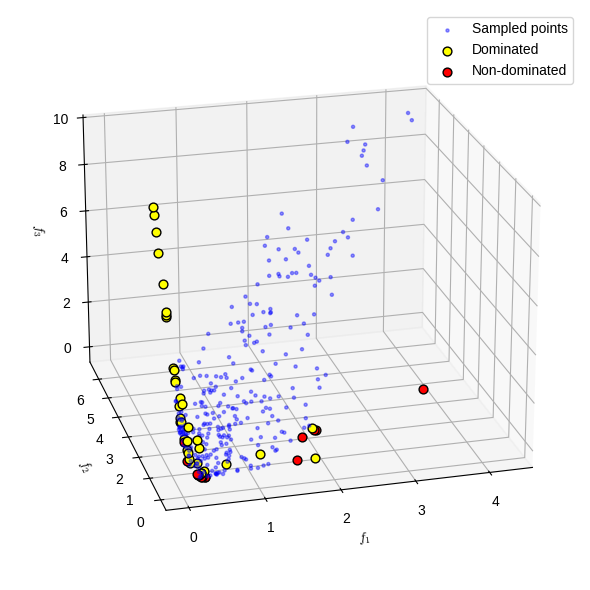

In [19]:
# ==========================================================
#  Multi-start – Brown-Dennis (não convexa)
# ==========================================================
import time
import numpy as np
import matplotlib.pyplot as plt
from  scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(7)   # reprodutibilidade
# 1) Configurações de fonte (MathText => Computer Modern)
plt.rcParams['text.usetex']      = False
plt.rcParams['font.family']      = 'serif'
plt.rcParams['font.serif']       = ['Computer Modern']
plt.rcParams['mathtext.fontset'] = 'cm'


# ==========================================================
#  Dados do problema Brown-Dennis
# ==========================================================
t1, t2, t3 = 1/5, 2/5, 3/5
bounds     = [(-0.1, 0.1), (-5, 5), (-5, 5), (-10, 10)]   # caixa viável
num_starts = 50
max_iter   = 50

# ==================================================
#  Função objetivo e seus gradientes
# ====================================================
def F(x):
    A = [x[0] + t1*x[1] - np.exp(t1),
         x[0] + t2*x[1] - np.exp(t2),
         x[0] + t3*x[1] - np.exp(t3)]
    B = [x[2] + x[3]*np.sin(t1),
         x[2] + x[3]*np.sin(t2),
         x[2] + x[3]*np.sin(t3)]
    return np.array([A[0]**2 + B[0]**2,
                     A[1]**2 + B[1]**2,
                     A[2]**2 + B[2]**2])

def grad_F(x):
    """Gradiente de F"""
    grads = []
    for t in (t1, t2, t3):
        A = x[0] + t*x[1] - np.exp(t)
        B = x[2] + x[3]*np.sin(t)
        grads.append([ 2*A,
                       2*t*A,
                       2*B,
                       2*np.sin(t)*B ])
    return np.array(grads)

# ==========================================================
#  Busca de direção por SLSQP
# ==========================================================
def buscadirecao(x, bounds, tol=1e-10):
    G   = grad_F(x)                       # matriz de gradientes
    dt0 = np.concatenate([np.zeros_like(x), [0.0]])

    fun_obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    fun_obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrições de t
    cons = [{'type': 'ineq',
             'fun' : lambda dt, i=i: dt[-1] - np.dot(G[i], dt[:-1])}
            for i in range(3)]

    # restrições de caixa para x+d
    for i, (lo, up) in enumerate(bounds):
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,up=up:  up - (x[i] + dt[i])})
        cons.append({'type':'ineq', 'fun': lambda dt,i=i,lo=lo: (x[i] + dt[i]) - lo})

    res = minimize(fun_obj, dt0, jac=fun_obj_grad, constraints=cons,
                   method='SLSQP',
                   options={'ftol': tol, 'maxiter': 500, 'disp': False})

    d_opt = res.x[:-1]       # direção ótima
    phi   = fun_obj(res.x)   # phi(d*)
    return d_opt, phi


# ==============================================
#  Armijo não-monótono
# ============================================
def Armijo_tamanho_passo(z, d, F_fun, JF_vec, A_k, delta):
    """
    Critério de Armijo não-monótono (máximo) em vetor:
      F(z + αd) ≤ A_k + delta t JF_vec
    Busca α = 1/2^j, j = 0,…,19.
    """
    for j in range(20):
        alpha = 1 / (2**j)
        if np.all(F_fun(z + alpha*d) <= A_k + delta*alpha*JF_vec):
            return alpha
    return 1.0


def compute_A_k(valores_F, k, M=10):
    """
    A_k = máximo componente-a-componente dos últimos min(k,M) valores de F.
    """
    m_k   = min(k, M)
    recentes = valores_F[max(0, k-m_k): k+1]
    return np.max(recentes, axis=0) if recentes else valores_F[-1]


# ==========================================================
#  Projeção na caixa
# =======================================================
def proj_caixa(x, bounds):
    lo = np.array([lo for lo, _ in bounds])
    up = np.array([up for _,  up in bounds])
    return np.clip(x, lo, up)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
#  Execução do PGMMOP
# ==========================================================
def PGMMOP(x0, bounds, max_iter=50, M=10, delta=0.5, tol=1e-8):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      phi_hist – histórico de phi(d^k)
    """
    x       = x0.copy()
    f_hist  = []
    phi_hist  = []

    for k in range(max_iter):
        Fx = F(x); f_hist.append(Fx)

        d, phi = buscadirecao(x, bounds)
        phi_hist.append(phi)

        if np.linalg.norm(d) <= tol:
            break

        A_k   = compute_A_k(f_hist, k, M)
        JFd   = grad_F(x) @ d                    # vetor 3
        t     = Armijo_tamanho_passo(x, d, F, JFd, A_k, delta)
        x     = proj_caixa(x + t*d, bounds)

    return x, d, k, phi, F(x), phi_hist

# ==========================================================
#  Loop multi-start
# ==========================================================
sol_dec, sol_obj = [], []
t_total = time.time()

print("\n===== RESULTADOS DO MULTI-START (Brown-Dennis) =====")

for run in range(num_starts):
    x0 = np.array([np.random.uniform(lo, up) for lo, up in bounds])
    x_opt, d_last, iters, φ_fin, F_opt, γ_hist = PGMMOP(
        x0, bounds, max_iter=max_iter)

    sol_dec.append(x_opt)
    sol_obj.append(F_opt)
    print(f"Partida {run+1:2d}: iter={iters:2d}  φ={φ_fin:.2e}  F(x*)={F_opt}")

print(f"\nTempo total: {time.time() - t_total:.2f} s")

# ==========================================================
#  Amostragem adicional no espaço de decisão (para visualização)
# ============================================
x_ref   = np.mean(sol_dec, axis=0)
sigma   = np.array([(up - lo) * 0.15 for lo, up in bounds])
amostras= np.array([proj_caixa(x_ref + np.random.uniform(-sigma, sigma),
                               bounds)
                    for _ in range(300)])
obj_am  = np.array([F(s) for s in amostras])

# ==========================================================
#  Verificação de dominância
def domina(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return np.all(a <= b) and np.any(a < b)

dom, nao_dom = [], []
for i, sol in enumerate(sol_obj):
    se_dom = any(domina(o, sol) for j, o in enumerate(sol_obj) if j != i)
    if not se_dom:
        se_dom = any(domina(p, sol) for p in obj_am)
    (dom if se_dom else nao_dom).append(sol)

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
#  Plot 3-D no espaço dos objetivos
# ==========================================================
fig = plt.figure(figsize=(9, 6))
ax  = fig.add_subplot(111, projection='3d')
ax.view_init(elev=22, azim=-105)

# Amostras geradas em azul
ax.scatter(obj_am[:,0], obj_am[:,1], obj_am[:,2],
           s=5, alpha=0.4, color="blue", label="Sampled points")

# Soluções dominadas em amarelo
for p in dom:
    ax.scatter(*p, s=40, color="yellow", edgecolor="black",
               label="Dominated"
               if "Dominated" not in ax.get_legend_handles_labels()[1] else "")

# Soluções não dominadas em vermelho
for p in nao_dom:
    ax.scatter(*p, s=40, color="red", edgecolor="black",
               label="Non-dominated"
               if "Non-dominated" not in ax.get_legend_handles_labels()[1] else "")

ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
ax.set_zlabel("$f_3$")
ax.legend()
plt.tight_layout()
plt.show()


===== Resultados Multi-Start =====

--- Início 1 ---
Ponto inicial (após projeção): [0.60008755 3.23450083 1.43467593 2.16541162]
Ponto ótimo x*: [0.         3.53454461 0.53454461 2.46545539]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 2
Valor final de phi: 0.0
Imagem da solução ótima F(x*): [np.float64(-3.5345446096577278), np.float64(3.5345446096577278)]

--- Início 2 ---
Ponto inicial (após projeção): [0.54333922 1.91332156 0.         3.54333922]
Ponto ótimo x*: [0.54333922 1.91332156 0.         3.54333922]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 0
Valor final de phi: 0.0
Imagem da solução ótima F(x*): [np.float64(-1.3699823430683438), np.float64(2.9999999999989173)]

--- Início 3 ---
Ponto inicial (após projeção): [3.70006618 0.         4.40013236 2.29993382]
Ponto ótimo x*: [7.66644606e-01 1.46671079e+00 2.22044605e-16 3.76664461e+00]
Vetor do subproblema final: [0. 0. 0. 0.]
Número de iterações: 8
Valor final de phi: 0.0
Imagem da solução

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


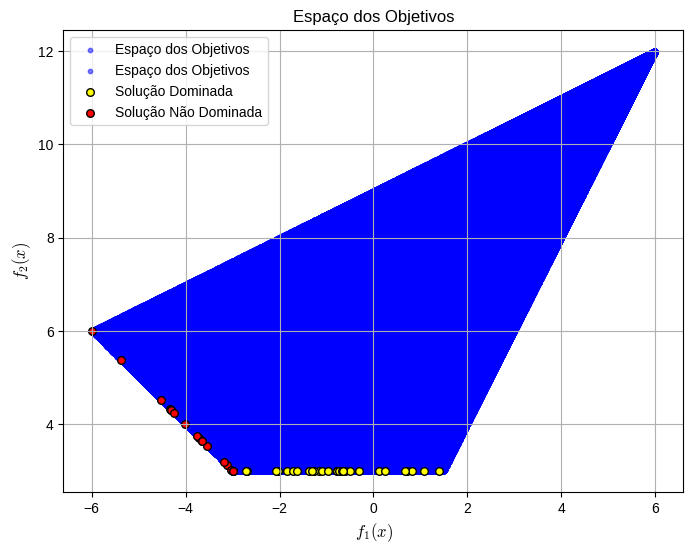

In [26]:
# ==========================================================
#  Multi-start – Exemplo do trabalho (convexo)
# ==========================================================
import time  # Importa o módulo para medição de tempo
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pygmo as pg  # Certifique-se de instalar o PyGMO (pip install pygmo)
from matplotlib.patches import Polygon


# 1) Use MathText sem LaTeX externo, mas com Computer Modern
plt.rcParams['text.usetex']        = False
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.serif']         = ['Computer Modern']
plt.rcParams['mathtext.fontset']   = 'cm'


import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#=================================================================
# FUNÇÃO: PROBLEMA 4 NO TRABALHO
#================================================================
def proj_hyperplane(x, w, cte):
    """
    Projeta o ponto x no hiperplano definido por <w,x> = cte.
    """
    w_dot_x = np.dot(w, x)
    w_dot_w = np.dot(w, w)
    return x + (cte - w_dot_x) / w_dot_w * w

def proj_halfspace(x, idx, cte=0):
    """
    Projeta o ponto x no semiespaço definido por x[idx] >= cte.
    """
    if x[idx] < cte:
        x_new = x.copy()
        x_new[idx] = cte
        return x_new
    else:
        return x

def dykstra(z, maxcycles=500):
    """
    Projeta z (em R^4) sobre a interseção dos conjuntos:
    Hiperplano 1: 2x1 + x2 - x3 = 3
  Hiperplano 2: x1 + x2 + x4 = 6
    Semiespaços: x1 >= 0, x2 >= 0, x3 >= 0, x4 >= 0
    """
    x = z.copy()
    # Inicializa os vetores de correção para cada restrição
    d1 = np.zeros(4)  # para hiperplano 1
    d2 = np.zeros(4)  # para hiperplano 2
    d3 = np.zeros(4)  # para x1 >= 0
    d4 = np.zeros(4)  # para x2 >= 0
    d5 = np.zeros(4)  # para x3 >= 0
    d6 = np.zeros(4)  # para x4 >= 0
    errors = []

    for k in range(maxcycles):
        err = 0

        # Projeção no Hiperplano 1: 2x1 + x2 - x3 = 3
        temp = x.copy()
        x = proj_hyperplane(x - d1, np.array([2, 1, -1, 0]), 3)
        d1 = x - (temp - d1)
        err += np.linalg.norm(x - temp)**2

        # Projeção no Hiperplano 2: x1 + x2 + x4 = 6
        temp = x.copy()
        x = proj_hyperplane(x - d2, np.array([1, 1, 0, 1]), 6)
        d2 = x - (temp - d2)
        err += np.linalg.norm(x - temp)**2

        # Projeção no Semiespaço: x1 >= 0 (índice 0)
        temp = x.copy()
        x = proj_halfspace(x - d3, 0, 0)
        d3 = x - (temp - d3)
        err += np.linalg.norm(x - temp)**2

        # Projeção no Semiespaço: x2 >= 0 (índice 1)
        temp = x.copy()
        x = proj_halfspace(x - d4, 1, 0)
        d4 = x - (temp - d4)
        err += np.linalg.norm(x - temp)**2

        # Projeção no Semiespaço: x3 >= 0 (índice 2)
        temp = x.copy()
        x = proj_halfspace(x - d5, 2, 0)
        d5 = x - (temp - d5)
        err += np.linalg.norm(x - temp)**2

        # Projeção no Semiespaço: x4 >= 0 (índice 3)
        temp = x.copy()
        x = proj_halfspace(x - d6, 3, 0)
        d6 = x - (temp - d6)
        err += np.linalg.norm(x - temp)**2

        errors.append(np.sqrt(err))
        if np.sqrt(err) < 1e-12:
            break
    return x, errors

def proj(z):
    """
    Função wrapper para projeção via Dykstra.
    """
    x, _ = dykstra(z)
    return x

#===========================================
# FUNÇÃO OBJETIVO E SEUS GRADIENTES
#=========================================
def F(x):
    """
    Função objetivo F: R^4 -> R^2
      f1(x)= x1 - x2
      f2(x)= 2x1 + x2
    Obs.: x é um vetor de dimensão 4.
    """
    f1 = x[0] - x[1]
    f2 = 2 * x[0] + x[1]
    return [f1, f2]

def funcaogradF(x):
    """
    Gradiente da função objetivo F.
      grad f1, grad f2
    """
    grad_f1 = np.array([1, -1, 0, 0])
    grad_f2 = np.array([2,  1, 0, 0])
    return grad_f1, grad_f2

#============================================
# Busca de dreção por SLSQP
#=========================================================

def buscadirecao(x, tol_eps=1e-10):
    """
    Resolve o sub-problema epígrafe via SLSQP e devolve (d*, phi).
    """
    G   = np.array(funcaogradF(x))
    dt0 = np.concatenate([np.zeros_like(x), [0.0]])

    # fun-objetivo
    obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrição de t
    cons = [{'type': 'ineq',
             'fun' : lambda dt, i=i: dt[-1] - np.dot(G[i], dt[:-1])}
            for i in range(2)]

    # hiperplanos
    cons += [
        {'type': 'eq',
         'fun' : lambda dt: np.dot([2,1,-1,0], x+dt[:-1]) - 3},
        {'type': 'eq',
         'fun' : lambda dt: np.dot([1,1,0,1], x+dt[:-1]) - 6},
    ]
    # semiespaços xj>= 0
    for j in range(4):
        cons.append({'type': 'ineq',
                     'fun': lambda dt, j=j: (x+dt[:-1])[j]})

    res = minimize(obj, dt0, jac=obj_grad,
                   constraints=cons, method='SLSQP',
                   options={'ftol': tol_eps, 'maxiter': 500, 'disp': False})

    d_opt = res.x[:-1]
    phi   = obj(res.x)
    return d_opt, phi




def Armijo_tamanho_passo(z, d, F, J, A_k, delta):
    """
    Seleciona tamanho de passo t através do critério de Armijo não-monótono do tipo máximo..
    Parâmetros:
    z : Ponto atual (x,y)
    d : Direção de busca obtida pelo SLSQP
    F : Função objetivo.
    J : Avaliação do gradiente em z na direção d
    A_k : Par (A₁, A₂) acumulado nas últimas iterações.
    delta : Parâmetro usado apenas em Armijo.

    Retorna: O maior tamanho de passo t=1/2^j (j = 0, 1, ...,19) que satisfaz a cond. de Armijo
        F(z + td) ≤ A_k + δ t J;
        retorna 1.0 se nenhum j satisfizer.
    """
    for j in range(30):
        t_val = 1/(2**j)
        z_next = z + t_val*d
        F_next = np.array(F(z_next))
        rhs = np.array(A_k) + delta*t_val*J
        if np.all(F_next <= rhs):
            return t_val
    return 1


def compute_A_k(f_values, k, M=10):
    """
    Calcula o valor de A_k para Armijo não-monótono.

    Parâmetros usados:
    f_values : Histórico de valores de F(z) (cada um sendo um vetor de dimensão 2).
    k : índice da iteração atual.
    M : Número máximo de iterações consideradas em A_k (M=10).

    Retorna:
    A_k : Par (A₁, A₂), onde cada componente é o máximo de F_j nas últimas min(k, M) iterações.
    """
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k) : k+1] #Seleciona o conjunto de valores F(z^j) desde j = k–m_k até j = k
    if not recentes:  # Caso k=0 e f_values tem só um elemento
        return f_values[-1]
    A1 = max(f[0] for f in recentes)
    A2 = max(f[1] for f in recentes)
    return (A1, A2)

def jacobian_F(x):
    """
    Calcula a Jacobiana de F usando os gradientes.
    """
    grad_f1, grad_f2 = funcaogradF(x)
    return np.array([grad_f1, grad_f2])

#=========================================================
# ALGORITMO DE OTIMIZAÇÃO COM MULTI-START
#========================================================
def PGMMOP(x0, max_iter=50, M=10, delta=0.5, tol=1e-8):
    """
      Devolve:
        x*          ponto final
        d_last      direção da última iteração
        k           nº de iterações executadas
        phi_last    phi final
        F(x*)       imagem final
        phi_hist   histórico de phi(d^k)
      """
    x = x0.copy()
    f_history  = []
    phi_history  = []

    for k in range(max_iter):
        Fx = F(x);               f_history.append(Fx)

        d, phi_val = buscadirecao(x) #busca a direção por SLSQP
        phi_history.append(phi_val) # Guarda valores de phi na lista


        if np.linalg.norm(d) <= tol: #critério de parada
            break

        A_k = compute_A_k(f_history, k, M)   # Armijo não-monótono
        J         = jacobian_F(x)          # 2x4
        JF_d = J @ d                  # vetor 2
        t         = Armijo_tamanho_passo(x, d, F, JF_d, A_k, delta)
        x = proj(x + t*d)                  # usa a projeção de Dykstra

    return x, d, k, phi_val, F(x)

# Número de pontos de início no multi‑start (pode ser modificado)
n_starts = 50
solucoes = []         # Armazena os pontos ótimos x*
imagens_sol = []   # Armazena as imagens F(x*) correspondentes

# Gerar pontos iniciais aleatórios em R^4 e projeção para a região viável
np.random.seed(0)
initial_points = []
for i in range(n_starts):
    x_rand = np.random.uniform(-6,5, 4)#2 a 7
    x0_proj = proj(x_rand)
    initial_points.append(x0_proj)

print("===== Resultados Multi-Start =====")
start_time = time.perf_counter()  # Inicia a medição do tempo

for i, x0 in enumerate(initial_points):
    x_opt, subproblem_vec, iters, final_phi, Fx = PGMMOP(x0)
    solucoes.append(x_opt)
    imagens_sol.append(Fx)
    print(f"\n--- Início {i+1} ---")
    print("Ponto inicial (após projeção):", x0)
    print("Ponto ótimo x*:", x_opt)
    print("Vetor do subproblema final:", subproblem_vec)
    print("Número de iterações:", iters)
    print("Valor final de phi:", final_phi)
    print("Imagem da solução ótima F(x*):", Fx)

end_time = time.perf_counter()  # Finaliza a medição do tempo
print(f"\nTempo de execução do multi‑start: {end_time - start_time:.4f} segundos")

#==================================
# GERAÇÃO DO ESPAÇO DOS OBJETIVOS
#==================================
# Gerar pontos que satisfaçam:
#   x1 >= 0, x2 >= 0,
#   x4 = 6 - x1 - x2 >= 0   (implica x1+x2 <= 6)
#   x3 = 2*x1 + x2 - 3 >= 0  (implica 2*x1+x2 >= 3)
num_points = 4000000
obj_samples = []
for _ in range(num_points):
    x1 = np.random.uniform(0, 6)      # x1 em [0,6]
    x2 = np.random.uniform(0, 6 - x1)   # para garantir x1+x2 <= 6
    x4 = 6 - x1 - x2
    x3 = 2*x1 + x2 - 3
    if x4 >= 0 and x3 >= 0:
        obj_samples.append([x1, x2, x3, x4])
obj_samples = np.array(obj_samples)
objective_values = np.array([F(x) for x in obj_samples])
f1_values = objective_values[:, 0]
f2_values = objective_values[:, 1]

#======================================
# VERIFICAÇÃO DE DOMINÂNCIA ENTRE OS PONTOS ÓTIMOS
#======================================
def domina(sol1, sol2):
    """
    Retorna True se sol1 domina sol2, ou seja, se sol1 é
    menor ou igual a sol2 em todas as componentes e estritamente
    menor em pelo menos uma.
    """
    sol1 = np.array(sol1)
    sol2 = np.array(sol2)
    return np.all(sol1 <= sol2) and np.any(sol1 < sol2)

# ===== PASSO 1 =====
# Verifica dominância entre as imagens dos pontos ótimos obtidos pelo multi‑start.
print("\n===== Verificação de Dominância ENTRE os Pontos Ótimos (Passo 1) =====")
nao_dominadas_otimas = []     # imagens que sobrevivem à Etapa 1
dominadas_otimas     = []     # imagens dominadas por outra ótima

for i, sol in enumerate(imagens_sol):
    dominado = False
    for j, outra_sol in enumerate(imagens_sol):
        if i != j and domina(outra_sol, sol):
            dominado = True
            break
    if dominado:
        dominadas_otimas.append(sol)
        print(f"Solução {i+1} com imagem F(x*) = {sol} é DOMINADA entre os pontos ótimos.")
    else:
        nao_dominadas_otimas.append(sol)
        print(f"Solução {i+1} com imagem F(x*) = {sol} NÃO é dominada entre os pontos ótimos.")

# ===== PASSO 2 =====
# Para cada ponto que não foi dominado no Passo 1, verifica-se se ele é dominado por algum ponto do espaço dos objetivos.
print("\n===== Verificação de Dominância DAS SOLUÇÕES NÃO DOMINADAS (Passo 2) em relação ao Espaço dos Objetivos =====")
nao_dominadas_finais = []      # permaneceram não-dominadas
dominadas_pelo_espaco = []     # dominadas por algum ponto gerado
for sol in nao_dominadas_otimas:
    dominada = any(domina(pt, sol) for pt in objective_values)
    if dominada:
        dominadas_pelo_espaco.append(sol)
        print(f"Solução F(x*) = {sol} foi DOMINADA pelo espaço de amostras.")
    else:
        nao_dominadas_finais.append(sol)
        print(f"Solução F(x*) = {sol} NÃO foi dominada pelo espaço de amostras.")


# Vai unificar as soluções dominadas (seja por outros ótimos ou pelo espaço dos objetivos)
dominadas_finais = dominadas_otimas + dominadas_pelo_espaco

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

#===================================================================
# PLOT DO ESPAÇO DOS OBJETIVOS COM A CLASSIFICAÇÃO DOS PONTOS ÓTIMOS
#===================================================================
plt.figure(figsize=(8,6))
# Pontos gerados para o espaço dos objetivos (azul)
plt.scatter(f1_values, f2_values, alpha=0.5, s=10, marker='o', color="blue", label="Espaço dos Objetivos")

# Espaço amostrado (azul)
plt.scatter(f1_values, f2_values, s=10, alpha=0.5, color="blue",
            label="Espaço dos Objetivos")

# Soluções dominadas (amarelo)
for sol in dominadas_finais:
    plt.scatter(sol[0], sol[1], s=30, color="yellow", edgecolor="black",
                label="Solução Dominada"
                if "Solução Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

# Soluções não-dominadas (vermelho)
for sol in nao_dominadas_finais:
    plt.scatter(sol[0], sol[1], s=30, color="red", edgecolor="black",
                label="Solução Não Dominada"
                if "Solução Não Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Espaço dos Objetivos", fontsize=12)
plt.xlabel(r"$f_1(x)$", fontsize=12)
plt.ylabel(r"$f_2(x)$", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



===== RESULTADOS DO MULTI-START (Fonseca-Fleming) =====

— Partida 1
Ponto inicial: [0.09762701 0.43037873]
Ponto ótimo: [0.2432398  0.24325574]
Iterações: 10  φ final: 0.0  F(x*): [0.34970577 0.83574703]

— Partida 2
Ponto inicial: [0.20552675 0.08976637]
Ponto ótimo: [0.14627931 0.14626481]
Iterações: 8  φ final: 0.0  F(x*): [0.46691328 0.76695201]

— Partida 3
Ponto inicial: [-0.1526904   0.29178823]
Ponto ótimo: [0.05934617 0.05936239]
Iterações: 8  φ final: 0.0  F(x*): [0.56792954 0.69115789]

— Partida 4
Ponto inicial: [-0.12482558  0.783546  ]
Ponto ótimo: [0.1697287  0.16973829]
Iterações: 11  φ final: 0.0  F(x*): [0.43872265 0.78512477]

— Partida 5
Ponto inicial: [ 0.92732552 -0.23311696]
Ponto ótimo: [0.11999484 0.11997827]
Iterações: 11  φ final: 0.0  F(x*): [0.49813309 0.74542678]

— Partida 6
Ponto inicial: [0.58345008 0.05778984]
Ponto ótimo: [0.2590618  0.25904666]
Iterações: 11  φ final: 0.0  F(x*): [0.33068614 0.8454031 ]

— Partida 7
Ponto inicial: [0.13608912 0.851

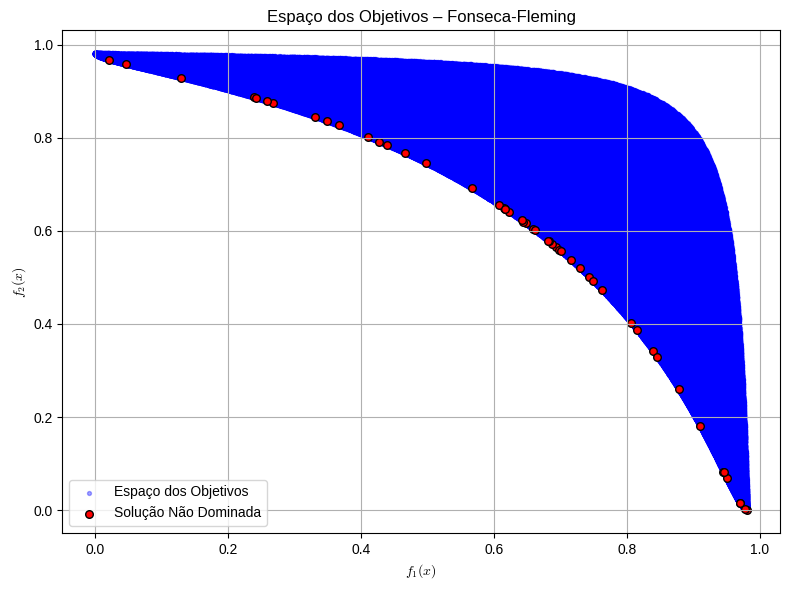

In [27]:
# ==========================================================
#  Multi-start – Função Fonseca-Fleming (não-convexa)
# ==========================================================
# !pip install pygmo

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(0)                             # semente para reprodução

#  Fonte Computer Modern (sem LaTeX externo)
plt.rcParams['text.usetex']      = False
plt.rcParams['font.family']      = 'serif'
plt.rcParams['font.serif']       = ['Computer Modern']
plt.rcParams['mathtext.fontset'] = 'cm'

import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
#  Função objetivo – Fonseca-Fleming
# ==========================================================

def F(x):
    """
    f₁(x) = 1 − exp(−[(x_1−1/sqrt(2))² + (x_2−1/sqrt(2))²])
    f₂(x) = 1 − exp(−[(x_1+1/sqrt(2))² + (x_2+1/sqrt(2))²])
    """
    s = 1/np.sqrt(2)
    t1 = (x[0] - s)**2 + (x[1] - s)**2
    t2 = (x[0] + s)**2 + (x[1] + s)**2
    return np.array([1 - np.exp(-t1),
                     1 - np.exp(-t2)])


def grad_F(x):
    """
    Gradientes de f₁ e f₂ (R² => R²).
    """
    s = 1/np.sqrt(2)
    t1 = (x[0] - s)**2 + (x[1] - s)**2
    t2 = (x[0] + s)**2 + (x[1] + s)**2
    g1 = 2*np.exp(-t1) * np.array([x[0] - s, x[1] - s])
    g2 = 2*np.exp(-t2) * np.array([x[0] + s, x[1] + s])
    return g1, g2

# ==========================================================
#  Projeção (caixa + disco)
# ==========================================================

def proj_caixa(x):                       # −1 <= x_i x_i 1
    return np.clip(x, -1.0, 1.0)

def proj_disco(x):                       # ||X|| ≤ 1
    n = np.linalg.norm(x)
    return x if n <= 1 else x / n

def dykstra(z, max_ciclos=500, tol=1e-12):
    """
    Projeta z na interseção caixa∩disco usando Dykstra.
    """
    x      = z.copy()
    d_box  = np.zeros_like(x)
    d_disk = np.zeros_like(x)

    for _ in range(max_ciclos):
        err  = 0.0
        temp = x.copy()
        x    = proj_caixa(x - d_box);  d_box  = x - (temp - d_box)
        err += np.linalg.norm(x - temp)**2

        temp = x.copy()
        x    = proj_disco(x - d_disk); d_disk = x - (temp - d_disk)
        err += np.linalg.norm(x - temp)**2

        if np.sqrt(err) < tol:
            break
    return x

def proj(x):
    """Chama a projeção por Dykstra"""
    return dykstra(x)

# ==========================================================
#  Busca da direção por SLSQP
# ==========================================================

def buscadirecao(x, tol=1e-10):
    g1, g2 = grad_F(x)
    dt0    = np.concatenate([np.zeros_like(x), [0.0]])

    obj      = lambda dt: dt[-1] + 0.5*np.dot(dt[:-1], dt[:-1])
    obj_grad = lambda dt: np.concatenate([dt[:-1], [1.0]])

    # restrição sobre t
    cons = [{'type':'ineq', 'fun':lambda dt: dt[-1] - np.dot(g1, dt[:-1])},
            {'type':'ineq', 'fun':lambda dt: dt[-1] - np.dot(g2, dt[:-1])}]

    # restrição de caixa
    for i in range(2):
        cons.append({'type':'ineq', 'fun':lambda dt,i=i:  (x[i]+dt[i]) + 1})
        cons.append({'type':'ineq', 'fun':lambda dt,i=i:  1 - (x[i]+dt[i])})
    #restricao do disco
    cons.append({'type':'ineq',
                 'fun':lambda dt: 1 - np.dot(x+dt[:-1], x+dt[:-1])})

    res = minimize(obj, dt0, jac=obj_grad,
                   constraints=cons, method='SLSQP',
                   options={'ftol': tol, 'maxiter': 500, 'disp': False})

    return res.x[:-1], obj(res.x)           # devolve d* e phi(d*)

# ==========================================================
#  5) Armijo vetorial e utilitários
# ==========================================================

def Armijo_tamanho_passo(z, d, F, J, A_k, delta):
    """
    Seleciona tamanho de passo t através do critério de Armijo não-monótono do tipo máximo..
    Parâmetros:
    z : Ponto atual (x,y)
    d : Direção de busca obtida pelo SLSQP
    F : Função objetivo.
    J : Avaliação do gradiente em z na direção d.
    A_k : Par (A₁, A₂) acumulado nas últimas iterações.
    delta : Parâmetro usado apenas em Armijo.

    Retorna: O maior tamanho de passo t=1/2^j (j = 0, 1, ...,29) que satisfaz a cond. de Armijo
        F(z + td) <= A_k + delta t J;
        retorna 1.0 se nenhum j satisfizer.
    """
    for j in range(30):
        t_val = 1/(2**j)
        z_next = z + t_val*d
        F_next = np.array(F(z_next))
        rhs = np.array(A_k) + delta*t_val*J
        if np.all(F_next <= rhs):
            return t_val
    return 1


def compute_A_k(f_values, k, M=10):
    """
    Calcula o valor de A_k para Armijo não-monótono.

    Parâmetros usados:
    f_values : Histórico de valores de F(z) (cada um sendo um vetor de dimensão 2).
    k : índice da iteração atual.
    M : Número máximo de iterações consideradas em A_k (M=10).

    Retorna:
    A_k : Par (A₁, A₂), onde cada componente é o máximo de F_j nas últimas min(k, M) iterações.
    """
    m_k = min(k, M)
    recentes = f_values[max(0, k-m_k) : k+1] #Seleciona o conjunto de valores F(z^j) desde j = k–m_k até j = k
    if not recentes:  # Caso k=0 e f_values tem só um elemento
        return f_values[-1]
    A1 = max(f[0] for f in recentes)
    A2 = max(f[1] for f in recentes)
    return (A1, A2)

def jacobiana_F(x):
    g1, g2 = grad_F(x)
    return np.array([g1, g2])

# ==========================================================
#  Função de otimização
# ==========================================================

def PGMMOP(x0, max_iter=50, M=10, δ=0.5, tol=1e-8):
    """
    Devolve:
      x*         – ponto final
      d_last     – direção da última iteração
      k          – nº de iterações executadas
      phi_last   – phi final
      F(x*)      – imagem final
      phi_hist – histórico de phi(d^k)
    """
    x       = x0.copy()
    hist_F  = []
    hist_phi = []


    for k in range(max_iter):
        Fx = F(x)
        hist_F.append(Fx)
        d, phi_final = buscadirecao(x)
        hist_phi.append(phi_final)
        if np.linalg.norm(d) <= tol:
            break

        A_k       = compute_A_k(hist_F, k, M)
        slope       = jacobiana_F(x) @ d
        t           = Armijo_tamanho_passo(x, d, F, slope, A_k, δ)

        x = proj(x + t*d)

    return x, d, k, phi_final, F(x),hist_phi

# ==========================================================
#  7) Loop multi-start
# ==========================================================

n_starts    = 50
solucoes_F  = []

print("\n===== RESULTADOS DO MULTI-START (Fonseca-Fleming) =====")
t0 = time.perf_counter()

for i in range(n_starts):
    x_ini = proj(np.random.uniform(-1, 1, 2))           # ponto viável
    x_opt, d_last, iters, phi_final, Fx,_ = PGMMOP(x_ini)
    solucoes_F.append(Fx)

    print(f"\n— Partida {i+1}")
    print("Ponto inicial:", x_ini)
    print("Ponto ótimo:", x_opt)
    print("Iterações:", iters, " φ final:", phi_final, " F(x*):", Fx)

print(f"\nTempo total: {time.perf_counter() - t0:.2f} s")

# ==========================================================
# Amostragem do espaço dos objetivos
# ==========================================================

N = 300_000
amostras  = []
while len(amostras) < N:
    cand = np.random.uniform(-1, 1, 2)
    if np.dot(cand, cand) <= 1:
        amostras.append(cand)
amostras       = np.array(amostras)
valores_obj    = np.array([F(p) for p in amostras])



# ==========================================================
#  filtro de dominância
# ==========================================================

def domina(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return np.all(a <= b) and np.any(a < b)

dom_d, dom_nd = [], []

for sol in solucoes_F:
    dominated = any(domina(outro, sol) for outro in solucoes_F
                    if not np.array_equal(sol, outro))
    if not dominated:
        dominated = any(domina(pt, sol) for pt in valores_obj)
    (dom_d if dominated else dom_nd).append(sol)



import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Liberation Sans', 'DejaVu Sans']

# ==========================================================
# Plot do espaço dos objetivos
# ==================================================

plt.figure(figsize=(8,6))
plt.scatter(valores_obj[:,0], valores_obj[:,1],
            s=8, alpha=0.35, color='blue', label="Espaço dos Objetivos")

for sol in dom_d:
    plt.scatter(*sol, s=30, color='yellow', edgecolor='black',
                label="Solução Dominada"
                if "Solução Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

for sol in dom_nd:
    plt.scatter(*sol, s=30, color='red', edgecolor='black',
                label="Solução Não Dominada"
                if "Solução Não Dominada" not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("Espaço dos Objetivos – Fonseca-Fleming")
plt.xlabel(r"$f_1(x)$")
plt.ylabel(r"$f_2(x)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
